# API

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pickle

In [2]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [56]:
# ipcluster start --engines=MPI -n 4
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from SYK import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [55]:
# %%writefile SYK.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib

class Params:
    def __init__(self,
    L=100,
    J=1,
    mu=0,
    kappa=0.5,
    dE=2,
    E0=0,
    history=False):
        self.L=L
        self.J=J
        self.mu=mu
        self.kappa=kappa
        self.variance=J**2/L
        self.dE=dE
        self.E0=E0
        self.history=history

        H=np.random.normal(0,J/np.sqrt(L),size=(L,L))
        H=(H+H.conj().T)/np.sqrt(2)+mu*np.eye(L)
        self.Hamiltonian=H
        
    def bandstructure(self):
        val,vec=nla.eigh(self.Hamiltonian)
        sortindex=np.argsort(val)
        self.val=val[sortindex]
        self.vec=vec[:,sortindex]

    def fermi_dist(self,energy,E_F=0):      
        assert self.dE is not None, 'dE is unspecified when T is inf'
        k=int(len(energy)*self.kappa)
        index=np.random.choice(np.arange(len(energy)),k,replace=False)
        E_mean=np.sum(energy[index])/self.L
        
        while np.abs(E_mean-self.E0)>self.dE:
            index=np.random.choice(np.arange(len(energy)),k,replace=False)
            E_mean=np.sum(energy[index])/self.L
        filt=np.zeros(len(energy),dtype=int)
        filt[index]=1
        self.index=index
        self.E_mean=E_mean
        return filt

    def correlation_matrix(self,E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>
        '''
        if not (hasattr(self,'val') and hasattr(self,'vec')):
            self.bandstructure()
        occupancy_mat=np.matlib.repmat(self.fermi_dist(self.val,E_F),self.vec.shape[0],1)
        self.C_f=((occupancy_mat*self.vec)@self.vec.T.conj())
    def covariance_matrix(self,E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self,'C_f'):
            if self.L<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G=self.C_f
        Gamma_11=1j*(G-G.T)
        Gamma_21=-(np.eye(G.shape[0])-G-G.T)
        Gamma_12=-Gamma_21.T
        Gamma_22=-1j*(G.T-G)
        Gamma=np.zeros((2*G.shape[0],2*G.shape[0]),dtype=complex)
        even=np.arange(2*G.shape[0])[::2]
        odd=np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even,even)]=Gamma_11
        Gamma[np.ix_(even,odd)]=Gamma_12
        Gamma[np.ix_(odd,even)]=Gamma_21
        Gamma[np.ix_(odd,odd)]=Gamma_22
        assert np.abs(np.imag(Gamma)).max()<1e-10, "Covariance matrix not real"        
        self.C_m=np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history=[self.C_m]

    def linearize_index(self,subregion,n,proj=False,k=2):
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        if proj:
            return sorted(np.concatenate([n*subregion+i for i in range(0,n,k)]))
        else:
            return sorted(np.concatenate([n*subregion+i for i in range(n)]))

    def c_subregion_m(self,subregion,Gamma=None):
        # subregion should be in the format of fermionic sites
        if not hasattr(self,'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregion=self.linearize_index(subregion,2)
        return Gamma[np.ix_(subregion,subregion)]

    def von_Neumann_entropy_m(self,subregion):
        c_A=self.c_subregion_m(subregion)
        val=nla.eigvalsh(1j*c_A)
        self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2+1e-18j   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_m(self,subregion_A,subregion_B):
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        s_A=self.von_Neumann_entropy_m(subregion_A)
        s_B=self.von_Neumann_entropy_m(subregion_B)
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB,(s_A,s_B,s_AB)
        
    def log_neg(self,subregionA,subregionB,Gamma=None):
        subregionA=self.linearize_index(subregionA,2)
        subregionB=self.linearize_index(subregionB,2)
        assert np.intersect1d(subregionA,subregionB).size==0 , "Subregion A and B overlap"
        if not hasattr(self,'C_m'):
            self.covariance_matrix()
        
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregionA=np.array(subregionA)
        subregionB=np.array(subregionB)
        Gm_p= np.block([
            [-Gamma[np.ix_(subregionA,subregionA)],1j*Gamma[np.ix_(subregionA,subregionB)]],
            [1j*Gamma[np.ix_(subregionB,subregionA)],Gamma[np.ix_(subregionB,subregionB)]]
        ])
        Gm_n= np.block([
            [-Gamma[np.ix_(subregionA,subregionA)],-1j*Gamma[np.ix_(subregionA,subregionB)]],
            [-1j*Gamma[np.ix_(subregionB,subregionA)],Gamma[np.ix_(subregionB,subregionB)]]
        ])
        idm=np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x=idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p),(idm+1j*Gm_n)))
        Gm_x=(Gm_x+Gm_x.T.conj())/2
        xi=nla.eigvalsh(Gm_x)
        subregionAB=np.concatenate([subregionA,subregionB])
        eA=np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi=nla.eigvalsh(1j*Gamma[np.ix_(subregionAB,subregionAB)])
        sA=np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        return np.real(eA+sA)

    def projection(self,s,type='onsite',ignore=False):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        For type:'link'
            (o,+)|(o,-)|(e,+)|(e,-)
        '''
        if type=='onsite':
            assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
            blkmat=np.array([[0,-(-1)**s,0,0],
                            [(-1)**s,0,0,0],
                            [0,0,0,(-1)**s],
                            [0,0,-(-1)**s,0]])
            return blkmat

        if type=='link':
            assert (s in ['o+','o-','e+','e-']), "s={} for {} is not defined".format(s,type)
            if not ignore:
                if s=='o+':
                    antidiag=[1,-1,1,-1]
                if s=='o-':
                    antidiag=[-1,1,-1,1]
                if s=='e+':
                    antidiag=[-1,-1,1,1]
                if s=='e-':
                    antidiag=[1,1,-1,-1]
                blkmat=np.diag(antidiag)
                blkmat=np.fliplr(blkmat)
            else:
                if s=='e+':
                    blkmat=np.array([[0,-1,0,0],
                                    [1,0,0,0],
                                    [0,0,0,-1],
                                    [0,0,1,0]])
                if s=='e-':
                    blkmat=-np.array([[0,-1,0,0],
                                    [1,0,0,0],
                                    [0,0,0,-1],
                                    [0,0,1,0]])
                if s=='o+':
                    antidiag=[1,-1,1,-1]
                    blkmat=np.diag(antidiag)
                    blkmat=np.fliplr(blkmat)
                if s=='o-':
                    antidiag=[-1,1,-1,1]
                    blkmat=np.diag(antidiag)
                    blkmat=np.fliplr(blkmat)

            proj=np.zeros((8,8))
            proj[:4,:4]=blkmat
            proj[4:,4:]=blkmat.T
            return proj            

        raise ValueError("type '{}' is not defined".format(type))

    def measure(self,s,ix,type='onsite',ignore=False):
        if not hasattr(self,'C_m'):
            self.covariance_matrix()
        if not hasattr(self,'s_history'):
            self.s_history=[]
        if not hasattr(self,'i_history'):
            self.i_history=[]
                
        m=self.C_m_history[-1].copy()

        for i_ind,i in enumerate(ix):
            m[[i,-(len(ix)-i_ind)]]=m[[-(len(ix)-i_ind),i]]
            m[:,[i,-(len(ix)-i_ind)]]=m[:,[-(len(ix)-i_ind),i]]

        self.m=m

        Gamma_LL=m[:-len(ix),:-len(ix)]
        Gamma_LR=m[:-len(ix),-len(ix):]
        Gamma_RR=m[-len(ix):,-len(ix):]       

        proj=self.projection(s,type=type,ignore=ignore)
        Upsilon_LL=proj[:-len(ix),:-len(ix)]
        Upsilon_RR=proj[-len(ix):,-len(ix):]
        Upsilon_RL=proj[-len(ix):,:-len(ix)]
        zero=np.zeros((m.shape[0]-len(ix),len(ix)))
        zero0=np.zeros((len(ix),len(ix)))
        mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
        mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
        mat3=np.block([[Gamma_RR,np.eye(len(ix))],[-np.eye(len(ix)),Upsilon_LL]])
        self.mat2=mat2
        if np.count_nonzero(mat2):
            Psi=mat1+mat2@(la.solve(mat3,mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi=mat1
        
        for i_ind,i in enumerate(ix):
            Psi[[i,-(len(ix)-i_ind)]]=Psi[[-(len(ix)-i_ind),i]]
            Psi[:,[i,-(len(ix)-i_ind)]]=Psi[:,[-(len(ix)-i_ind),i]]
        
        Psi=(Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(i)
        else:
            self.C_m_history=[Psi]
            self.s_history=[s]
            self.i_history=[i]


    def measure_all_Born(self,proj_range=None,type='onsite'):
        # proj_range should be in the format of fermionic sites
        if type=='onsite':
            if proj_range is None:
                proj_range=np.arange(self.L//4,self.L//2)

        if type=='link':
            if proj_range is None:
                proj_range=np.arange(self.L//4,self.L//2,2)
        proj_range=self.linearize_index(proj_range,2,proj=True,k=2)

        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        
        if type=='onsite':
            for i in proj_range:
                P_0=(self.C_m_history[-1][i,i+1]+1)/2
                if np.random.rand() < P_0:                
                    self.measure(0,[i,i+1])
                else:
                    self.measure(1,[i,i+1])
            return self
        if type=='link':
            for i in proj_range:
                Gamma=self.C_m_history[-1][i:i+4,i:i+4]
                gamma1234=-Gamma[0,1]*Gamma[2,3]+Gamma[0,2]*Gamma[1,3]-Gamma[0,3]*Gamma[1,2]
                P={}
                P['o+']=(1+Gamma[1,2]-Gamma[0,3]+gamma1234)/4
                P['o-']=(1-Gamma[1,2]+Gamma[0,3]+gamma1234)/4
                P['e+']=(1+Gamma[1,2]+Gamma[0,3]-gamma1234)/4
                P['e-']=(1-Gamma[1,2]-Gamma[0,3]-gamma1234)/4   
                assert P['o+']>-1e-12,'P[o+]={:e}'.format(P['o+'])     
                assert P['o-']>-1e-12,'P[o-]={:e}'.format(P['o-'])     
                assert P['e+']>-1e-12,'P[e+]={:e}'.format(P['e+'])     
                assert P['e-']>-1e-12,'P[e-]={:e}'.format(P['e-'])  
                P['o+']=max([0,P['o+']])
                P['o-']=max([0,P['o-']])
                P['e+']=max([0,P['e+']])
                P['e-']=max([0,P['e-']])
                s=np.random.choice(['o+','o-','e+','e-'],p=[P['o+'],P['o-'],P['e+'],P['e-']])
                self.measure(s,[i,i+1,i+2,i+3],type='link')
            return self
        raise ValueError("type '{}' is not defined".format(type))

Overwriting SYK.py


In [41]:
max(2,3)

3

In [3]:
list(range(0,4,4))

[0]

In [82]:
params=Params(L=1000,J=1)

In [83]:
params.von_Neumann_entropy_m(np.arange(params.L//2))/params.L

0.19259942464653676

In [41]:
params.C_m.shape

(2000, 2000)

In [101]:
p_rate=0.5

In [120]:
L=32
params=Params(L=L)
subA=np.arange(0,L//2)
subB=np.arange(L//2,L)
tot=np.arange(L)
proj_range_bool=np.random.choice([0,1],size=tot.shape[0],p=[1-p_rate,p_rate])
proj_range=tot[proj_range_bool==1]   
params.measure_all_Born(proj_range=proj_range)

In [121]:
proj_range

array([ 1,  2,  4,  6,  7, 10, 13, 15, 18, 19, 20, 21, 22, 24, 25, 26, 29])

In [122]:
np.diag(params.C_m_history[-1],1)[::2]

array([ 0.65257354,  1.        ,  1.        ,  0.17077765, -1.        ,
       -0.06548415, -1.        , -1.        , -0.5103109 ,  0.03379465,
        1.        , -0.0555374 ,  0.13344322,  1.        ,  0.41336164,
       -1.        ,  0.64398406,  0.33509085,  1.        , -1.        ,
       -1.        ,  1.        , -1.        ,  0.340534  , -1.        ,
       -1.        , -1.        ,  0.4765071 ,  0.06769256,  1.        ,
       -0.09536924,  0.45894241])

# Spectrum

In [15]:
param=Params(L=1000)
param.bandstructure()

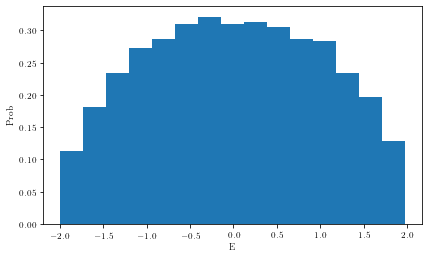

In [16]:
fig,ax=plt.subplots()
ax.hist(param.val,bins=15,density=True)

ax.set_xlabel('E')
ax.set_ylabel('Prob')
fig.savefig('/mnt/d/KITP/Rp_SPT/11/semicircle.pdf')

# Onsite/Link-no

In [51]:
with open('/mnt/d/kitp/Rp_SPT/12/inf_T_SYK_onsite_ApBp_sametype.pickle','rb') as f:
# with open('inf_T_SYK_onsite_ApBp_sametype.pickle','rb') as f:
    MI_0_onsite_sametype_dict,LN_0_onsite_sametype_dict,MI_onsite_sametype_dict,LN_onsite_sametype_dict,E_onsite_sametype_mean=pickle.load(f)

In [52]:
E_list=np.linspace(-0.1,0.1,10)
L=256
LN_onsite_mean={}
LN_onsite_std={}
LN_0_onsite_mean={}
LN_0_onsite_std={}
ensemble_onsite={}
LN_onsite_mean[L]=[]
LN_onsite_std[L]=[]
LN_0_onsite_mean[L]=[]
LN_0_onsite_std[L]=[]
ensemble_onsite[L]=[]
LN_onsite= np.array(LN_onsite_sametype_dict[L])
LN_0_onsite= np.array(LN_0_onsite_sametype_dict[L])
E_onsite=np.array(E_onsite_sametype_mean[L])
for E in E_list:
    dE=0.05
    mask=np.logical_and((E-dE)<E_onsite_sametype_mean[L],E_onsite_sametype_mean[L]<(E+dE))
    ensemble_onsite[L].append(LN_onsite[(mask)].shape[0])
    LN_0_onsite_mean[L].append(LN_0_onsite[mask].mean())
    LN_0_onsite_std[L].append(LN_0_onsite[mask].std()/np.sqrt(LN_onsite[(mask)].shape[0]))
    LN_onsite_mean[L].append(LN_onsite[mask].mean())
    LN_onsite_std[L].append(LN_onsite[mask].std()/np.sqrt(LN_onsite[(mask)].shape[0]))



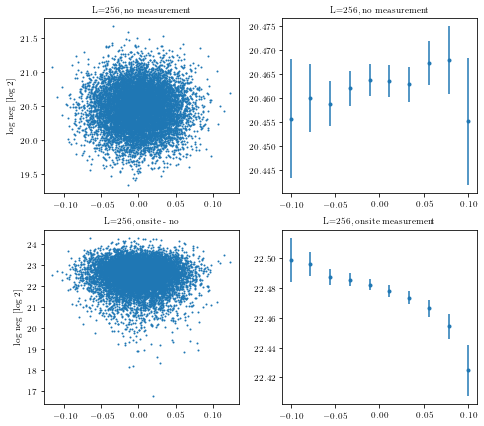

In [53]:
fig,axs=plt.subplots(2,2,figsize=(6.8,6),tight_layout=True)
# L=128

ax=axs[0,0]
ax.scatter(E_onsite_sametype_mean[L],np.array(LN_0_onsite_sametype_dict[L])/np.log(2),s=1)
ax.set_ylabel('log neg [log 2]')
ax.set_title('L={}, no measurement'.format(L))

ax=axs[1,0]
ax.scatter(E_onsite_sametype_mean[L],np.array(LN_onsite_sametype_dict[L])/np.log(2)-np.array(LN_0_onsite_sametype_dict[L])/np.log(2),s=1)
ax.set_ylabel('log neg [log 2]')
ax.set_title('L={}, onsite - no'.format(L))


ax=axs[0,1]
ax.errorbar(E_list,LN_0_onsite_mean[L]/np.log(2),LN_0_onsite_std[L]/np.log(2),fmt='.')
ax.set_title('L={}, no measurement'.format(L))

ax=axs[1,1]
ax.errorbar(E_list,(np.array(LN_onsite_mean[L])-np.array(LN_0_onsite_mean[L]))/np.log(2),(np.array(LN_onsite_std[L])-np.array(LN_0_onsite_std[L]))/np.log(2),fmt='.')
ax.set_title('L={}, onsite measurement'.format(L))

fig.savefig('/mnt/d/kitp/Rp_SPT/12/LN_SYK_L{}_onsite_no_ApBp.pdf'.format(L))
# fig.savefig('/mnt/d/kitp/Rp_SPT/12/LN_SYK_L{}_onsite_no.pdf'.format(L))

In [21]:
with open('/mnt/d/kitp/Rp_SPT/12/inf_T_SYK_link_ApBp_sametype.pickle','rb') as f:
# with open('inf_T_SYK_onsite_Ap_sametype.pickle','rb') as f:
    MI_0_link_sametype_dict,LN_0_link_sametype_dict,MI_link_sametype_dict,LN_link_sametype_dict,E_link_sametype_mean=pickle.load(f)

In [24]:
# E_list=np.linspace(-0.1,0.1,10)
E_list=np.linspace(-0.05,0.05,10)
L=512
LN_link_mean={}
LN_link_std={}
LN_0_link_mean={}
LN_0_link_std={}
ensemble_onsite={}
LN_link_mean[L]=[]
LN_link_std[L]=[]
LN_0_link_mean[L]=[]
LN_0_link_std[L]=[]
ensemble_onsite[L]=[]
LN_onsite= np.array(LN_link_sametype_dict[L])
LN_0_onsite= np.array(LN_0_link_sametype_dict[L])
E_onsite=np.array(E_link_sametype_mean[L])
for E in E_list:
    dE=0.05
    mask=np.logical_and((E-dE)<E_link_sametype_mean[L],E_link_sametype_mean[L]<(E+dE))
    ensemble_onsite[L].append(LN_onsite[(mask)].shape[0])
    LN_0_link_mean[L].append(LN_0_onsite[mask].mean())
    LN_0_link_std[L].append(LN_0_onsite[mask].std()/np.sqrt(LN_onsite[(mask)].shape[0]))
    LN_link_mean[L].append(LN_onsite[mask].mean())
    LN_link_std[L].append(LN_onsite[mask].std()/np.sqrt(LN_onsite[(mask)].shape[0]))



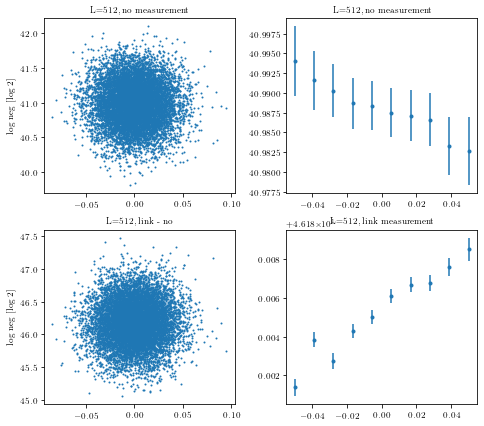

In [25]:
fig,axs=plt.subplots(2,2,figsize=(6.8,6),tight_layout=True)

ax=axs[0,0]
ax.scatter(E_link_sametype_mean[L],np.array(LN_0_link_sametype_dict[L])/np.log(2),s=1)
ax.set_ylabel('log neg [log 2]')
ax.set_title('L={}, no measurement'.format(L))

ax=axs[1,0]
ax.scatter(E_link_sametype_mean[L],np.array(LN_link_sametype_dict[L])/np.log(2)-np.array(LN_0_link_sametype_dict[L])/np.log(2),s=1)
ax.set_ylabel('log neg [log 2]')
ax.set_title('L={}, link - no'.format(L))


ax=axs[0,1]
ax.errorbar(E_list,LN_0_link_mean[L]/np.log(2),LN_0_link_std[L]/np.log(2),fmt='.')
ax.set_title('L={}, no measurement'.format(L))

ax=axs[1,1]
ax.errorbar(E_list,(np.array(LN_link_mean[L])-np.array(LN_0_link_mean[L]))/np.log(2),(np.array(LN_link_std[L])-np.array(LN_0_link_std[L]))/np.log(2),fmt='.')
ax.set_title('L={}, link measurement'.format(L))

# fig.savefig('/mnt/d/kitp/Rp_SPT/12/LN_SYK_L{}_link_no.pdf'.format(L))
fig.savefig('/mnt/d/kitp/Rp_SPT/12/LN_SYK_L{}_link_no_ApBp.pdf'.format(L))

In [28]:
(0.052 *256+0.03)/np.log(2)

19.24843723554055

In [29]:
(0.056 *256+-0.04)/np.log(2)

20.624768304548624

# EE

In [84]:
EE_dict={}

In [90]:
es=100
L=100
m_list=np.arange(1,L//2+1,5)
kappa_list=[.1,.3,.5,.8]
for kappa in kappa_list:
    EE_dict[kappa]=np.zeros((m_list.shape[0],es))

    for m_i,m in enumerate(m_list):
        EE=[Params(L=L,E0=0,kappa=kappa).von_Neumann_entropy_m(np.arange(m))/(L) for _ in range(es)]
        EE_dict[kappa][m_i,:]=EE

In [61]:
import scipy.integrate as integrate

def func(kappa,lamb):
    lamb_p=(np.sqrt(kappa*(1-lamb))+np.sqrt(lamb*(1-kappa)))**2
    lamb_m=(np.sqrt(kappa*(1-lamb))-np.sqrt(lamb*(1-kappa)))**2
    integrand=lambda x:1/(2*np.pi*lamb)*np.sqrt((lamb_p-x)*(x-lamb_m))/(x*(1-x))*(-x*np.log(x)-(1-x)*np.log(1-x))
    integral=integrate.quad(integrand,lamb_m,lamb_p)
    return integral[0]

In [60]:
analy_dict={}
for kappa in kappa_list:
    analy_dict[kappa]=[lamb*func(kappa,lamb) for lamb in m_list/(L)]

NameError: name 'kappa_list' is not defined

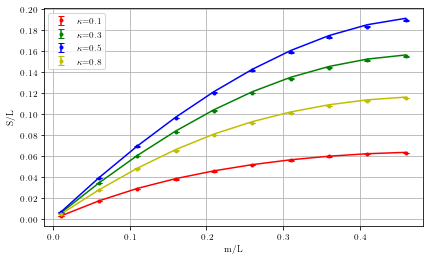

In [98]:
fig,ax=plt.subplots()
color_list='rgby'
for kappa,color in zip(kappa_list,color_list):
    ax.errorbar(m_list/(L),EE_dict[kappa].mean(axis=1),EE_dict[kappa].std(axis=1)/np.sqrt(es),fmt='.',capsize=3,label='$\kappa$={:.1f}'.format(kappa),color=color)
ax.grid('on')
ax.legend()
for kappa,color in zip(kappa_list,color_list):
    ax.plot(m_list/(L),analy_dict[kappa],color=color)
ax.set_yticks(np.linspace(0,0.2,11))
ax.set_xlabel('m/L')
ax.set_ylabel('S/L')
fig.savefig('/mnt/d/KITP/Rp_SPT/11/EE_SYK.pdf')

In [95]:
EE_random_dict={}
es=100
L=100
m_list=np.arange(1,L//2+1,5)
kappa_list=[.1,.3,.5,.8]
for kappa in kappa_list:
    EE_random_dict[kappa]=np.zeros((m_list.shape[0],es))

    for m_i,m in enumerate(m_list):
        m_rand_list=(np.random.choice(np.arange(L),m,replace=False))

        EE_random=[Params(L=L,E0=0,dE=0.01,kappa=kappa).von_Neumann_entropy_m(m_rand_list)/(L) for _ in range(es)]
        EE_random_dict[kappa][m_i,:]=EE_random

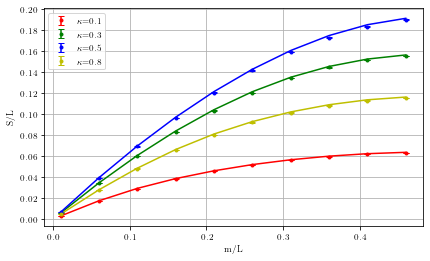

In [99]:
fig,ax=plt.subplots()
color_list='rgby'
for kappa,color in zip(kappa_list,color_list):
    ax.errorbar(m_list/(L),EE_random_dict[kappa].mean(axis=1),EE_random_dict[kappa].std(axis=1)/np.sqrt(es),fmt='.',capsize=3,label='$\kappa$={:.1f}'.format(kappa),color=color)
ax.grid('on')
ax.legend()
for kappa,color in zip(kappa_list,color_list):
    ax.plot(m_list/(L),analy_dict[kappa],color=color)
ax.set_yticks(np.linspace(0,0.2,11))
ax.set_xlabel('m/L')
ax.set_ylabel('S/L')
fig.savefig('/mnt/d/KITP/Rp_SPT/11/EE_rand_SYK.pdf')

# Measurement

In [24]:
es=20
L_list=np.arange(16,256+1,16)
MI_no_list=[]
for L in L_list:
    MI_no_list.append([Params(L=L).mutual_information_m(np.arange(L//4),np.arange(L//4)+L//2) for _ in range(es)])
MI_no_list=np.array(MI_no_list)

In [50]:
params=Params()

In [51]:
params.measure_all_Born()

In [120]:
es=100
L_list=np.arange(16,256+1,16)
MI_no_list=np.zeros((L_list.shape[0],es))
LN_no_list=np.zeros((L_list.shape[0],es))
def run(p):
    L=p
    params=Params(L=L)
    MI=params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    LN=params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    return MI,LN

for L_i,L in enumerate(L_list):
    sync_results=rc[:].map_sync(run,[L]*es)
    for es_i,result in enumerate(sync_results):
        MI,LN=result
        MI_no_list[L_i,es_i]=MI
        LN_no_list[L_i,es_i]=LN

In [121]:
es=100
L_list=np.arange(16,256+1,16)
MI_onsite_list=np.zeros((L_list.shape[0],es))
LN_onsite_list=np.zeros((L_list.shape[0],es))
def run(p):
    L=p
    params=Params(L=L)
    params.measure_all_Born()
    MI=params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    LN=params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    return MI,LN

for L_i,L in enumerate(L_list):
    sync_results=rc[:].map_sync(run,[L]*es)
    for es_i,result in enumerate(sync_results):
        MI,LN=result
        MI_onsite_list[L_i,es_i]=MI
        LN_onsite_list[L_i,es_i]=LN

In [114]:
params=Params(L=100)
params.measure_all_Born()

In [38]:
es=10
L_list=np.arange(16,256+1,16)
MI_onsiteApBp_list=np.zeros((L_list.shape[0],es))
LN_onsiteApBp_list=np.zeros((L_list.shape[0],es))
def run(p):
    L=p
    params=Params(L=L)
    params.measure_all_Born()
    params.measure_all_Born(proj_range=np.arange(params.L//4,params.L//2)+params.L//2)
    MI=params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    LN=params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    return MI,LN

for L_i,L in enumerate(L_list):
    sync_results=rc[:].map_sync(run,[L]*es)
    for es_i,result in enumerate(sync_results):
        MI,LN,S_A,S_B,S_AB=result
        MI_onsiteApBp_list[L_i,es_i]=MI
        LN_onsiteApBp_list[L_i,es_i]=LN

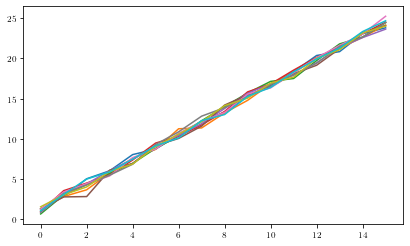

In [39]:
plt.plot(S_A_onsiteApBp_list)

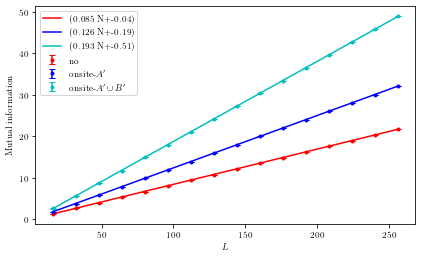

In [123]:
fig,ax=plt.subplots()
ax.errorbar(L_list,MI_no_list.mean(axis=1),MI_no_list.std(axis=1)/es,fmt='.',capsize=3,label='no',color='r')
ax.errorbar(L_list,MI_onsite_list.mean(axis=1),MI_onsite_list.std(axis=1)/es,fmt='.',capsize=3,label='onsite-$A^\prime$',color='b')
ax.errorbar(L_list,MI_onsiteApBp_list.mean(axis=1),MI_onsite_list.std(axis=1)/es,fmt='.',capsize=3,label='onsite-$A^\prime \cup B^\prime$',color='c')

ax.set_xlabel('$L$')
ax.set_ylabel('Mutual information')

lr_no=scipy.stats.linregress(L_list,MI_no_list.mean(axis=1))
ax.plot(L_list,lr_no.slope*L_list+lr_no.intercept,color='r',label='({:.3f} N+{:.2f})'.format(lr_no.slope,lr_no.intercept))


lr_onsite=scipy.stats.linregress(L_list,MI_onsite_list.mean(axis=1))
ax.plot(L_list,lr_onsite.slope*L_list+lr_onsite.intercept,color='b',label='({:.3f} N+{:.2f})'.format(lr_onsite.slope,lr_onsite.intercept))

lr_onsiteApBp=scipy.stats.linregress(L_list,MI_onsiteApBp_list.mean(axis=1))
ax.plot(L_list,lr_onsiteApBp.slope*L_list+lr_onsiteApBp.intercept,color='c',label='({:.3f} N+{:.2f})'.format(lr_onsiteApBp.slope,lr_onsiteApBp.intercept))
ax.legend()
fig.savefig('/mnt/d/kitp/Rp_SPT/11/MI_SYK.pdf')

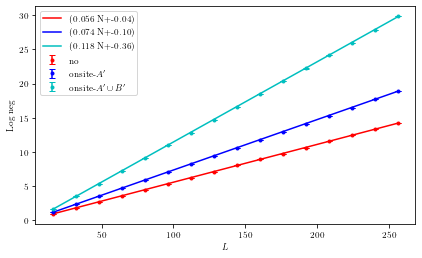

In [124]:
fig,ax=plt.subplots()
ax.errorbar(L_list,LN_no_list.mean(axis=1),LN_no_list.std(axis=1)/es,fmt='.',capsize=3,label='no',color='r')
ax.errorbar(L_list,LN_onsite_list.mean(axis=1),LN_onsite_list.std(axis=1)/es,fmt='.',capsize=3,label='onsite-$A^\prime$',color='b')
ax.errorbar(L_list,LN_onsiteApBp_list.mean(axis=1),LN_onsite_list.std(axis=1)/es,fmt='.',capsize=3,label='onsite-$A^\prime \cup B^\prime$',color='c')

ax.set_xlabel('$L$')
ax.set_ylabel('Log neg')

lr_no=scipy.stats.linregress(L_list,LN_no_list.mean(axis=1))
ax.plot(L_list,lr_no.slope*L_list+lr_no.intercept,color='r',label='({:.3f} N+{:.2f})'.format(lr_no.slope,lr_no.intercept))


lr_onsite=scipy.stats.linregress(L_list,LN_onsite_list.mean(axis=1))
ax.plot(L_list,lr_onsite.slope*L_list+lr_onsite.intercept,color='b',label='({:.3f} N+{:.2f})'.format(lr_onsite.slope,lr_onsite.intercept))

lr_onsiteApBp=scipy.stats.linregress(L_list,LN_onsiteApBp_list.mean(axis=1))
ax.plot(L_list,lr_onsiteApBp.slope*L_list+lr_onsiteApBp.intercept,color='c',label='({:.3f} N+{:.2f})'.format(lr_onsiteApBp.slope,lr_onsiteApBp.intercept))
ax.legend()
fig.savefig('/mnt/d/kitp/Rp_SPT/11/LN_SYK.pdf')

In [27]:
lr=scipy.stats.linregress(L_list,MI_no_list.mean(axis=1))


In [28]:
lr.slope

0.08503251101979027

In [58]:
lr=scipy.stats.linregress(L_list,MI_onsite_list.mean(axis=1))


In [59]:
lr.slope

0.12617555367980876

## Onsite measurment on tri-partite

In [ ]:
es=100
L_list=np.arange(16,256+1,16)
p_rate_list=np.arange(0,1.1,0.1)
MI_onsiterate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
LN_onsiterate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_A_onsiterate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_B_onsiterate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_AB_onsiterate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_onsiterate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    subAB=np.hstack((np.arange(L//4,L//2),np.arange(L//4,L//2)+L//2))
    proj_range_bool=np.random.choice([0,1],size=subAB.shape[0],p=[1-p_rate,p_rate])
    proj_range=subAB[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range)
    MI,(S_A,S_B,S_AB)=params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    LN=params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    proj_num=proj_range.shape[0]/L
    return MI,LN,proj_num,(S_A,S_B,S_AB)
for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            MI,LN,proj_num,(S_A,S_B,S_AB)=result
            MI_onsiterate_list[p_rate_i,L_i,es_i]=MI
            LN_onsiterate_list[p_rate_i,L_i,es_i]=LN
            proj_num_onsiterate_list[p_rate_i,L_i,es_i]=proj_num
            S_A_onsiterate_list[p_rate_i,L_i,es_i]=S_A
            S_B_onsiterate_list[p_rate_i,L_i,es_i]=S_B
            S_AB_onsiterate_list[p_rate_i,L_i,es_i]=S_AB


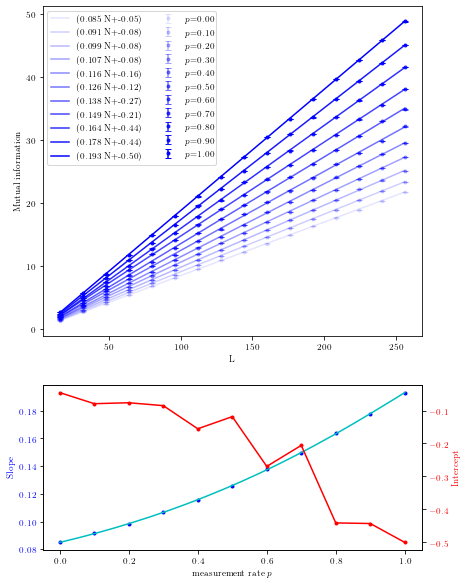

In [59]:
fig,axs=plt.subplots(2,1,figsize=(6.8,10),gridspec_kw=dict(height_ratios=[2,1]))
ax=axs[0]
lr_MI={}
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,MI_onsiterate_list[p_rate_i].mean(axis=1),MI_onsiterate_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)
    lr_MI[p_rate]=scipy.stats.linregress(L_list,MI_onsiterate_list[p_rate_i].mean(axis=1))
    ax.plot(L_list,lr_MI[p_rate].slope*L_list+lr_MI[p_rate].intercept,color='b',alpha=p_rate*.9+0.1,label='({:.3f} N+{:.2f})'.format(lr_MI[p_rate].slope,lr_MI[p_rate].intercept))

ax.set_xlabel('L')
ax.set_ylabel('Mutual information')
ax.legend(loc=2,ncol=2)

ax=axs[1]
ax.plot(p_rate_list,[lr_MI[p_rate].slope for p_rate in p_rate_list],'.b')
ax.plot(p_analy_list,MI_slope_analy_list,'c')
ax.set_xlabel('measurement rate $p$')
ax.set_ylabel('Slope',color='b')
ax.tick_params(axis='y', labelcolor='b')
ax2=ax.twinx()
ax2.plot(p_rate_list,[lr_MI[p_rate].intercept for p_rate in p_rate_list],'.-r')
ax2.set_ylabel('Intercept',color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.savefig('/mnt/d/kitp/Rp_SPT/11/MI_rate_SYK.pdf')

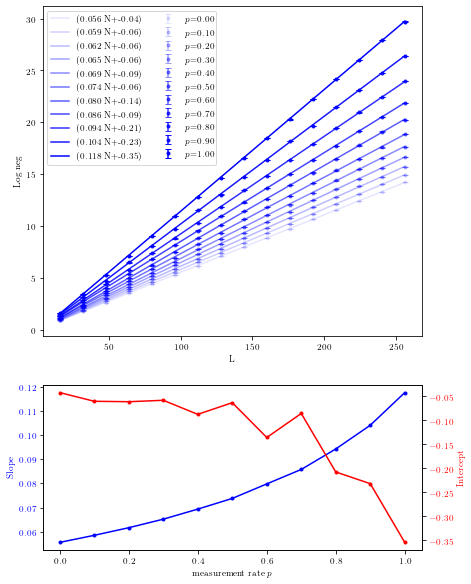

In [60]:
fig,axs=plt.subplots(2,1,figsize=(6.8,10),gridspec_kw=dict(height_ratios=[2,1]))
ax=axs[0]
lr_MI={}
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,LN_onsiterate_list[p_rate_i].mean(axis=1),LN_onsiterate_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)
    lr_MI[p_rate]=scipy.stats.linregress(L_list,LN_onsiterate_list[p_rate_i].mean(axis=1))
    ax.plot(L_list,lr_MI[p_rate].slope*L_list+lr_MI[p_rate].intercept,color='b',alpha=p_rate*.9+0.1,label='({:.3f} N+{:.2f})'.format(lr_MI[p_rate].slope,lr_MI[p_rate].intercept))

ax.set_xlabel('L')
ax.set_ylabel('Log neg')
ax.legend(loc=2,ncol=2)

ax=axs[1]
ax.plot(p_rate_list,[lr_MI[p_rate].slope for p_rate in p_rate_list],'.-b')
ax.set_xlabel('measurement rate $p$')
ax.set_ylabel('Slope',color='b')
ax.tick_params(axis='y', labelcolor='b')
ax2=ax.twinx()
ax2.plot(p_rate_list,[lr_MI[p_rate].intercept for p_rate in p_rate_list],'.-r')
ax2.set_ylabel('Intercept',color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.savefig('/mnt/d/kitp/Rp_SPT/11/LN_rate_SYK.pdf')

## Link measurement

In [9]:
es=100
L_list=np.arange(16,256+1,16)
p_rate_list=np.arange(0,1.1,0.1)
MI_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
LN_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_A_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_B_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_AB_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    subAB=np.hstack((np.arange(L//4,L//2,2),np.arange(L//4,L//2,2)+L//2))
    proj_range_bool=np.random.choice([0,1],size=subAB.shape[0],p=[1-p_rate,p_rate])
    proj_range=subAB[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range,type='link')
    MI,(S_A,S_B,S_AB)=params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    LN=params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    proj_num=proj_range.shape[0]/L
    return MI,LN,proj_num,(S_A,S_B,S_AB)
for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            MI,LN,proj_num,(S_A,S_B,S_AB)=result
            MI_linkrate_list[p_rate_i,L_i,es_i]=MI
            LN_linkrate_list[p_rate_i,L_i,es_i]=LN
            proj_num_linkrate_list[p_rate_i,L_i,es_i]=proj_num
            S_A_linkrate_list[p_rate_i,L_i,es_i]=S_A
            S_B_linkrate_list[p_rate_i,L_i,es_i]=S_B
            S_AB_linkrate_list[p_rate_i,L_i,es_i]=S_AB


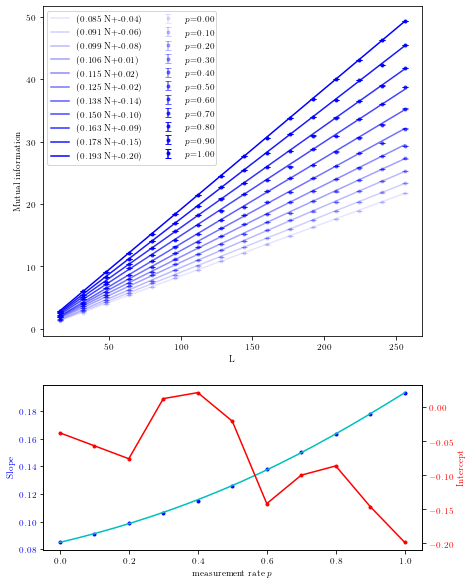

In [11]:
fig,axs=plt.subplots(2,1,figsize=(6.8,10),gridspec_kw=dict(height_ratios=[2,1]))
ax=axs[0]
lr_MI={}
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,MI_linkrate_list[p_rate_i].mean(axis=1),MI_linkrate_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)
    lr_MI[p_rate]=scipy.stats.linregress(L_list,MI_linkrate_list[p_rate_i].mean(axis=1))
    ax.plot(L_list,lr_MI[p_rate].slope*L_list+lr_MI[p_rate].intercept,color='b',alpha=p_rate*.9+0.1,label='({:.3f} N+{:.2f})'.format(lr_MI[p_rate].slope,lr_MI[p_rate].intercept))

ax.set_xlabel('L')
ax.set_ylabel('Mutual information')
ax.legend(loc=2,ncol=2)

ax=axs[1]
ax.plot(p_rate_list,[lr_MI[p_rate].slope for p_rate in p_rate_list],'.b')
ax.plot(p_analy_list,MI_slope_analy_list,'c')
ax.set_xlabel('measurement rate $p$')
ax.set_ylabel('Slope',color='b')
ax.tick_params(axis='y', labelcolor='b')
ax2=ax.twinx()
ax2.set_ylabel('Intercept',color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.plot(p_rate_list,[lr_MI[p_rate].intercept for p_rate in p_rate_list],'.-r')

fig.savefig('/mnt/d/kitp/Rp_SPT/11/MI_linkrate_SYK.pdf')

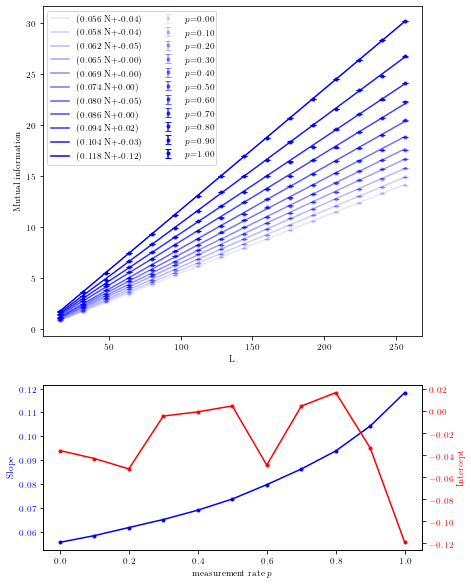

In [14]:
fig,axs=plt.subplots(2,1,figsize=(6.8,10),gridspec_kw=dict(height_ratios=[2,1]))
ax=axs[0]
lr_LN={}
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,LN_linkrate_list[p_rate_i].mean(axis=1),LN_linkrate_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)
    lr_LN[p_rate]=scipy.stats.linregress(L_list,LN_linkrate_list[p_rate_i].mean(axis=1))
    ax.plot(L_list,lr_LN[p_rate].slope*L_list+lr_LN[p_rate].intercept,color='b',alpha=p_rate*.9+0.1,label='({:.3f} N+{:.2f})'.format(lr_LN[p_rate].slope,lr_LN[p_rate].intercept))

ax.set_xlabel('L')
ax.set_ylabel('Mutual information')
ax.legend(loc=2,ncol=2)

ax=axs[1]
ax.plot(p_rate_list,[lr_LN[p_rate].slope for p_rate in p_rate_list],'.-b')
# ax.plot(p_analy_list,LN_slope_analy_list,'c')
ax.set_xlabel('measurement rate $p$')
ax.set_ylabel('Slope',color='b')
ax.tick_params(axis='y', labelcolor='b')
ax2=ax.twinx()
ax2.set_ylabel('Intercept',color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.plot(p_rate_list,[lr_LN[p_rate].intercept for p_rate in p_rate_list],'.-r')

fig.savefig('/mnt/d/kitp/Rp_SPT/11/LN_linkrate_SYK.pdf')

In [5]:
func(0.5,1/4)*(1/4*2)-func(0.5,1/2)*(1/2)

0.0849495183975793

In [13]:
func(1/2,1/2)*(1/4*2)

0.19314718055994745

In [15]:
p=1

In [7]:
p_analy_list=np.linspace(0,1,20)
MI_slope_analy_list=[func(1/2,1/(4-p*2))*(1/(4)*2)-func(1/2,2/(4-2*p))*(1/2) for p in p_analy_list]

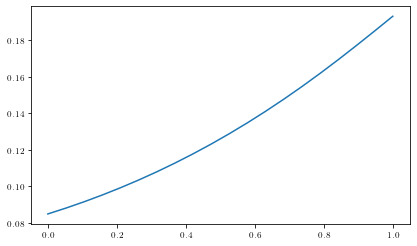

In [8]:
plt.plot(p_analy_list,MI_slope_analy_list)

In [ ]:
es=100
L_list=np.arange(16,256+1,16)
p_rate_list=np.arange(0,1.1,0.1)
MI_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
LN_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_A_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_B_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_AB_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_linkrate_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    subAB=np.hstack((np.arange(L//4,L//2),np.arange(L//4,L//2)+L//2))
    proj_range_bool=np.random.choice([0,1],size=subAB.shape[0],p=[1-p_rate,p_rate])
    proj_range=subAB[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range)
    MI,(S_A,S_B,S_AB)=params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    LN=params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)
    proj_num=proj_range.shape[0]/L
    return MI,LN,proj_num,(S_A,S_B,S_AB)
for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            MI,LN,proj_num,(S_A,S_B,S_AB)=result
            MI_linkrate_list[p_rate_i,L_i,es_i]=MI
            LN_linkrate_list[p_rate_i,L_i,es_i]=LN
            proj_num_linkrate_list[p_rate_i,L_i,es_i]=proj_num
            S_A_linkrate_list[p_rate_i,L_i,es_i]=S_A
            S_B_linkrate_list[p_rate_i,L_i,es_i]=S_B
            S_AB_linkrate_list[p_rate_i,L_i,es_i]=S_AB


In [137]:
[lr[p_rate].slope for p_rate in p_rate_list]

[0.0851743906781871,
 0.09101782569494248,
 0.09812323185872397,
 0.10611127553944631,
 0.1168074848783684,
 0.12761487451117523,
 0.13701246792903113,
 0.14969256372576603,
 0.16397371253819445,
 0.17707538474038598,
 0.19249979235833675]

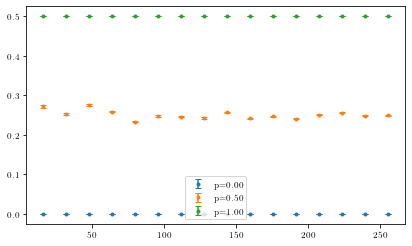

In [96]:
fig,ax=plt.subplots()
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,proj_num_onsiterate_list[p_rate_i].mean(axis=1),proj_num_onsiterate_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='p={:.2f}'.format(p_rate))
ax.legend()

## Show a bi-partite with measurement in all region/only one partition

### onsite

In [30]:
es=100
L_list=np.arange(16,256+1,16)
p_rate_list=np.arange(0,1.1,0.1)
MI_onsiterate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
LN_onsiterate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_A_onsiterate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_B_onsiterate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_onsiterate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    sub_A=np.arange(0,L//2)
    sub_B=np.arange(L//2,L)
    proj=np.arange(0,L//2)
    # subAB=np.hstack((np.arange(,L//2),np.arange(L//4,L//2)+L//2))
    proj_range_bool=np.random.choice([0,1],size=proj.shape[0],p=[1-p_rate,p_rate])
    proj_range=proj[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range)
    S_A=params.von_Neumann_entropy_m(sub_A)
    S_B=params.von_Neumann_entropy_m(sub_B)
    proj_num=proj_range.shape[0]/L
    return proj_num,S_A,S_B
for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            proj_num,S_A,S_B=result
            proj_num_onsiterate_A_list[p_rate_i,L_i,es_i]=proj_num
            S_A_onsiterate_A_list[p_rate_i,L_i,es_i]=S_A
            S_B_onsiterate_A_list[p_rate_i,L_i,es_i]=S_B


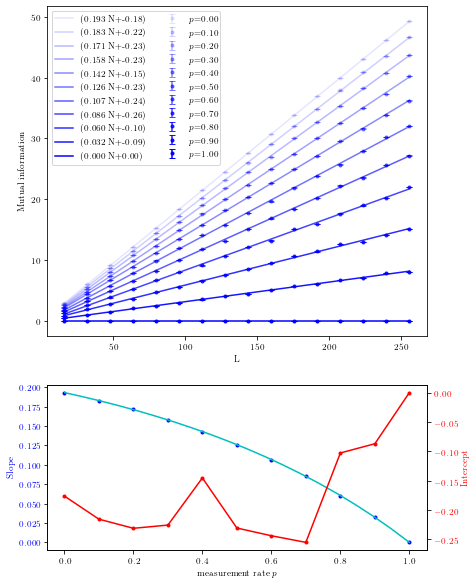

In [74]:
fig,axs=plt.subplots(2,1,figsize=(6.8,10),gridspec_kw=dict(height_ratios=[2,1]))
ax=axs[0]
lr_MI={}
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,S_A_onsiterate_A_list[p_rate_i].mean(axis=1),S_A_onsiterate_A_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)
    lr_MI[p_rate]=scipy.stats.linregress(L_list,S_A_onsiterate_A_list[p_rate_i].mean(axis=1))
    ax.plot(L_list,lr_MI[p_rate].slope*L_list+lr_MI[p_rate].intercept,color='b',alpha=p_rate*.9+0.1,label='({:.3f} N+{:.2f})'.format(lr_MI[p_rate].slope,lr_MI[p_rate].intercept))

ax.set_xlabel('L')
ax.set_ylabel('S_A')
ax.legend(loc=2,ncol=2)

ax=axs[1]
ax.plot(p_rate_list,[lr_MI[p_rate].slope for p_rate in p_rate_list],'.b')
ax.plot(p_analy_list,MI_slope_analy_list,'c')
ax.set_xlabel('measurement rate $p$')
ax.set_ylabel('Slope',color='b')
ax.tick_params(axis='y', labelcolor='b')
ax2=ax.twinx()
ax2.set_ylabel('Intercept',color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.plot(p_rate_list,[lr_MI[p_rate].intercept for p_rate in p_rate_list],'.-r')

fig.savefig('/mnt/d/kitp/Rp_SPT/12/S_A_onsiterate_A_SYK.pdf')

In [66]:
func(.5,0.0001)/2

0.3465485894465991

In [71]:
p_analy_list=np.linspace(0.001,1,20)
MI_slope_analy_list=[func(1/2,.5/(1-p*.5))/2 for p in p_analy_list]

In [77]:
es=100
L_list=np.arange(16,256+1,16)
p_rate_list=np.arange(0,1.1,0.1)
MI_onsiterate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
LN_onsiterate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_A_onsiterate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_B_onsiterate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_onsiterate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    sub_A=np.arange(0,L//2)
    sub_B=np.arange(L//2,L)
    proj=np.arange(0,L)
    # subAB=np.hstack((np.arange(,L//2),np.arange(L//4,L//2)+L//2))
    proj_range_bool=np.random.choice([0,1],size=proj.shape[0],p=[1-p_rate,p_rate])
    proj_range=proj[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range)
    S_A=params.von_Neumann_entropy_m(sub_A)
    S_B=params.von_Neumann_entropy_m(sub_B)
    proj_num=proj_range.shape[0]/L
    return proj_num,S_A,S_B
for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            proj_num,S_A,S_B=result
            proj_num_onsiterate_AB_list[p_rate_i,L_i,es_i]=proj_num
            S_A_onsiterate_AB_list[p_rate_i,L_i,es_i]=S_A
            S_B_onsiterate_AB_list[p_rate_i,L_i,es_i]=S_B


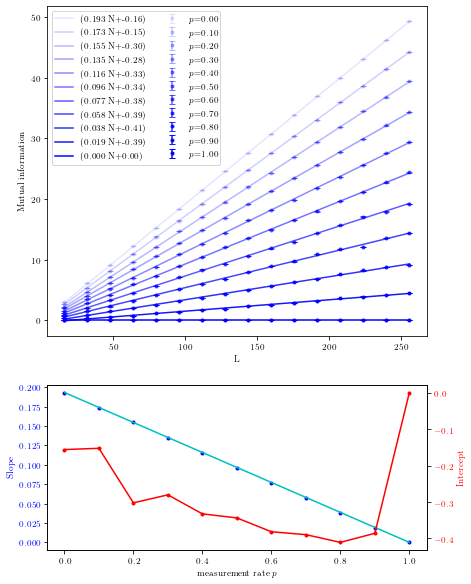

In [82]:
fig,axs=plt.subplots(2,1,figsize=(6.8,10),gridspec_kw=dict(height_ratios=[2,1]))
ax=axs[0]
lr_MI={}
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,S_A_onsiterate_AB_list[p_rate_i].mean(axis=1),S_A_onsiterate_AB_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)
    lr_MI[p_rate]=scipy.stats.linregress(L_list,S_A_onsiterate_AB_list[p_rate_i].mean(axis=1))
    ax.plot(L_list,lr_MI[p_rate].slope*L_list+lr_MI[p_rate].intercept,color='b',alpha=p_rate*.9+0.1,label='({:.3f} N+{:.2f})'.format(lr_MI[p_rate].slope,lr_MI[p_rate].intercept))

ax.set_xlabel('L')
ax.set_ylabel('S_A')
ax.legend(loc=2,ncol=2)

ax=axs[1]
ax.plot(p_rate_list,[lr_MI[p_rate].slope for p_rate in p_rate_list],'.b')
ax.plot(p_analy_list,MI_slope_analy_list,'c')
ax.set_xlabel('measurement rate $p$')
ax.set_ylabel('Slope',color='b')
ax.tick_params(axis='y', labelcolor='b')
ax2=ax.twinx()
ax2.set_ylabel('Intercept',color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.plot(p_rate_list,[lr_MI[p_rate].intercept for p_rate in p_rate_list],'.-r')

fig.savefig('/mnt/d/kitp/Rp_SPT/12/S_A_onsiterate_AB_SYK.pdf')

In [80]:
p_analy_list=np.linspace(0.001,1,20)
MI_slope_analy_list=[func(1/2,1/2)*(0.5-.5*p) for p in p_analy_list]

### link

In [64]:
es=100
L_list=np.arange(16,256+1,16)
p_rate_list=np.arange(0,1.1,0.1)
MI_linkrate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
LN_linkrate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_A_linkrate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_B_linkrate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_linkrate_A_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    sub_A=np.arange(0,L//2)
    sub_B=np.arange(L//2,L)
    proj=np.arange(0,L//2,2)
    # subAB=np.hstack((np.arange(,L//2),np.arange(L//4,L//2)+L//2))
    proj_range_bool=np.random.choice([0,1],size=proj.shape[0],p=[1-p_rate,p_rate])
    proj_range=proj[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range,type='link')
    S_A=params.von_Neumann_entropy_m(sub_A)
    S_B=params.von_Neumann_entropy_m(sub_B)
    proj_num=proj_range.shape[0]/L
    return proj_num,S_A,S_B
for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            proj_num,S_A,S_B=result
            proj_num_linkrate_A_list[p_rate_i,L_i,es_i]=proj_num
            S_A_linkrate_A_list[p_rate_i,L_i,es_i]=S_A
            S_B_linkrate_A_list[p_rate_i,L_i,es_i]=S_B


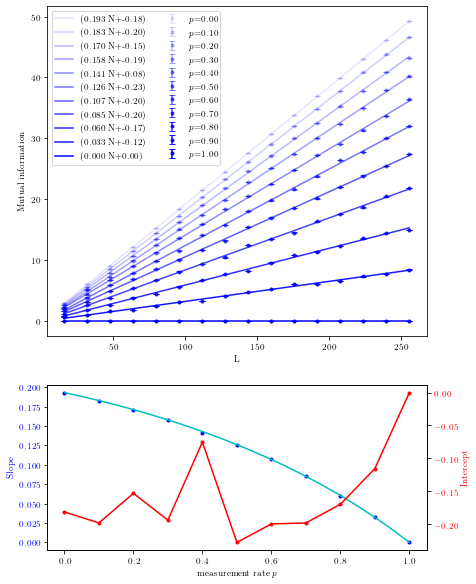

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,10),gridspec_kw=dict(height_ratios=[2,1]))
ax=axs[0]
lr_MI={}
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,S_A_linkrate_A_list[p_rate_i].mean(axis=1),S_A_linkrate_A_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)
    lr_MI[p_rate]=scipy.stats.linregress(L_list,S_A_linkrate_A_list[p_rate_i].mean(axis=1))
    ax.plot(L_list,lr_MI[p_rate].slope*L_list+lr_MI[p_rate].intercept,color='b',alpha=p_rate*.9+0.1,label='({:.3f} N+{:.2f})'.format(lr_MI[p_rate].slope,lr_MI[p_rate].intercept))

ax.set_xlabel('L')
ax.set_ylabel('$S_A$')
ax.legend(loc=2,ncol=2)

ax=axs[1]
ax.plot(p_rate_list,[lr_MI[p_rate].slope for p_rate in p_rate_list],'.b')
ax.plot(p_analy_list,MI_slope_analy_list,'c')
ax.set_xlabel('measurement rate $p$')
ax.set_ylabel('Slope',color='b')
ax.tick_params(axis='y', labelcolor='b')
ax2=ax.twinx()
ax2.set_ylabel('Intercept',color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.plot(p_rate_list,[lr_MI[p_rate].intercept for p_rate in p_rate_list],'.-r')

fig.savefig('/mnt/d/kitp/Rp_SPT/12/S_A_linkrate_A_SYK.pdf')

In [ ]:
p_analy_list=np.linspace(0.001,1,20)
MI_slope_analy_list=[func(1/2,.5/(1-p*.5))/2 for p in p_analy_list]

In [57]:
es=100
L_list=np.arange(16,256+1,16)
p_rate_list=np.arange(0.0,1.1,0.1)
MI_linkrate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
LN_linkrate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_A_linkrate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
S_B_linkrate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_linkrate_AB_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    sub_A=np.arange(0,L//2)
    sub_B=np.arange(L//2,L)
    proj=np.arange(0,L,2)
    # subAB=np.hstack((np.arange(,L//2),np.arange(L//4,L//2)+L//2))
    proj_range_bool=np.random.choice([0,1],size=proj.shape[0],p=[1-p_rate,p_rate])
    proj_range=proj[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range,type='link')
    S_A=params.von_Neumann_entropy_m(sub_A)
    S_B=params.von_Neumann_entropy_m(sub_B)
    proj_num=proj_range.shape[0]/L
    return proj_num,S_A,S_B
for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        # print('p={:.2f}, L={:d}'.format(p_rate,L))
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            proj_num,S_A,S_B=result
            proj_num_linkrate_AB_list[p_rate_i,L_i,es_i]=proj_num
            S_A_linkrate_AB_list[p_rate_i,L_i,es_i]=S_A
            S_B_linkrate_AB_list[p_rate_i,L_i,es_i]=S_B


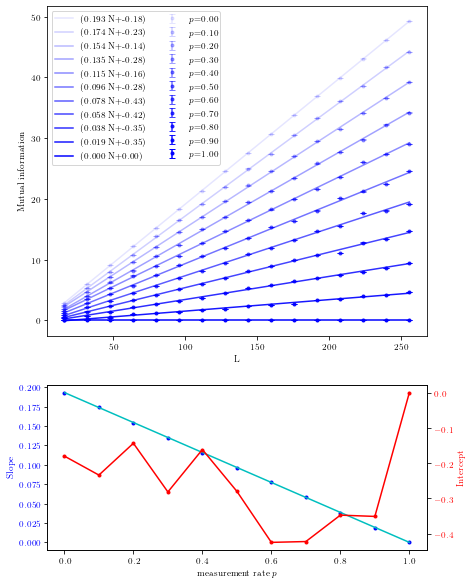

In [63]:
fig,axs=plt.subplots(2,1,figsize=(6.8,10),gridspec_kw=dict(height_ratios=[2,1]))
ax=axs[0]
lr_MI={}
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,S_A_linkrate_AB_list[p_rate_i].mean(axis=1),S_A_linkrate_AB_list[p_rate_i].std(axis=1)/es,fmt='.',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)
    lr_MI[p_rate]=scipy.stats.linregress(L_list,S_A_linkrate_AB_list[p_rate_i].mean(axis=1))
    ax.plot(L_list,lr_MI[p_rate].slope*L_list+lr_MI[p_rate].intercept,color='b',alpha=p_rate*.9+0.1,label='({:.3f} N+{:.2f})'.format(lr_MI[p_rate].slope,lr_MI[p_rate].intercept))

ax.set_xlabel('L')
ax.set_ylabel('Mutual information')
ax.legend(loc=2,ncol=2)

ax=axs[1]
ax.plot(p_rate_list,[lr_MI[p_rate].slope for p_rate in p_rate_list],'.b')
ax.plot(p_analy_list,MI_slope_analy_list,'c')
ax.set_xlabel('measurement rate $p$')
ax.set_ylabel('Slope',color='b')
ax.tick_params(axis='y', labelcolor='b')
ax2=ax.twinx()
ax2.set_ylabel('Intercept',color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.plot(p_rate_list,[lr_MI[p_rate].intercept for p_rate in p_rate_list],'.-r')

fig.savefig('/mnt/d/kitp/Rp_SPT/12/S_A_linkrate_AB_SYK.pdf')

In [62]:
p_analy_list=np.linspace(0.001,1,20)
MI_slope_analy_list=[func(1/2,1/2)*(0.5-.5*p) for p in p_analy_list]

### the following results has some issues with mutual info

In [ ]:
import pickle

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/11/EE_SYK_AB.pickle','wb') as f:
    pickle.dump([es,L_list,p_rate_list,MI_onsiterate_list,proj_num_onsiterate_list,S_A_onsiterate_list,S_B_onsiterate_list,S_AB_onsiterate_list],f)

In [ ]:
es=50
L_list=np.arange(16,1024+1,128)
p_rate_list=np.arange(0,1.1,0.2)
S_A_subA_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_subA_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    subA=np.arange(0,L//2);
    subB=np.arange(L//2,L);
    proj_range_bool=np.random.choice([0,1],size=subA.shape[0],p=[1-p_rate,p_rate])
    proj_range=subA[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range)
    S_A=params.von_Neumann_entropy_m(subA)
    proj_num=proj_range.shape[0]/L
    return S_A,proj_num

for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            S_A,proj_num=result
            proj_num_subA_list[p_rate_i,L_i,es_i]=proj_num
            S_A_subA_list[p_rate_i,L_i,es_i]=S_A

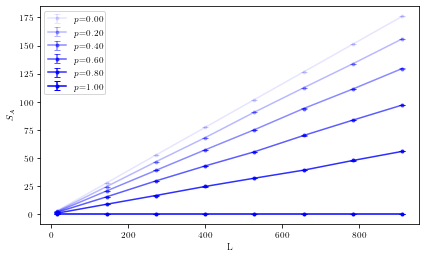

In [ ]:
fig,ax=plt.subplots()
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,S_A_subA_list[p_rate_i].mean(axis=1),S_A_subA_list[p_rate_i].std(axis=1)/es,fmt='.-',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)

ax.legend()
ax.set_xlabel('L')
ax.set_ylabel('$S_A$')

fig.savefig('/mnt/d/kitp/Rp_SPT/11/EE_SYK_SA.pdf')


In [ ]:
es=50
L_list=np.arange(16,1024+1,128)
p_rate_list=np.arange(0,1.1,0.2)
S_A_tot_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
proj_num_tot_list=np.zeros((p_rate_list.shape[0],L_list.shape[0],es))
def run(p):
    L,p_rate=p
    params=Params(L=L)
    subA=np.arange(0,L//2)
    subB=np.arange(L//2,L)
    tot=np.arange(L)
    proj_range_bool=np.random.choice([0,1],size=tot.shape[0],p=[1-p_rate,p_rate])
    proj_range=tot[proj_range_bool==1]   
    params.measure_all_Born(proj_range=proj_range)
    S_A=params.von_Neumann_entropy_m(subA)
    proj_num=proj_range.shape[0]/L
    return S_A,proj_num

for p_rate_i,p_rate in enumerate(p_rate_list):
    for L_i,L in enumerate(L_list):
        sync_results=rc[:].map_sync(run,[(L,p_rate)]*es)
        for es_i,result in enumerate(sync_results):
            S_A,proj_num=result
            proj_num_tot_list[p_rate_i,L_i,es_i]=proj_num
            S_A_tot_list[p_rate_i,L_i,es_i]=S_A

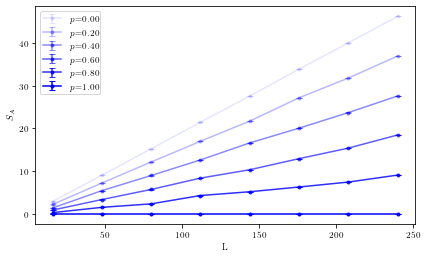

In [ ]:
fig,ax=plt.subplots()
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,S_A_tot_list[p_rate_i].mean(axis=1),S_A_tot_list[p_rate_i].std(axis=1)/es,fmt='.-',capsize=3,label='$p$={:.2f}'.format(p_rate),color='b',alpha=p_rate*.9+0.1)

ax.legend()
ax.set_xlabel('L')
ax.set_ylabel('$S_A$')

fig.savefig('/mnt/d/kitp/Rp_SPT/11/EE_SYK_tot.pdf')


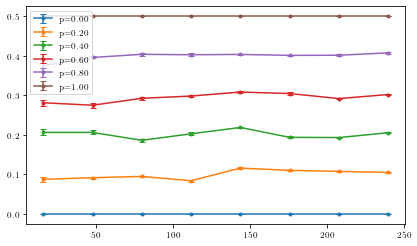

In [ ]:
fig,ax=plt.subplots()
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,proj_num_subA_list[p_rate_i].mean(axis=1),proj_num_subA_list[p_rate_i].std(axis=1)/es,fmt='.-',capsize=3,label='p={:.2f}'.format(p_rate))
ax.legend()

In [ ]:
# What if no Born rule is taken?

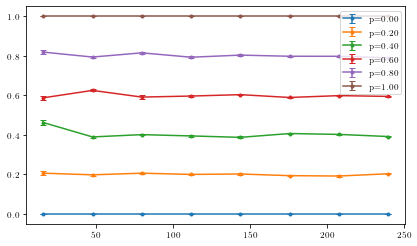

In [ ]:
fig,ax=plt.subplots()
for p_rate_i,p_rate in enumerate(p_rate_list):
    ax.errorbar(L_list,proj_num_tot_list[p_rate_i].mean(axis=1),proj_num_tot_list[p_rate_i].std(axis=1)/es,fmt='.-',capsize=3,label='p={:.2f}'.format(p_rate))
ax.legend()